# Reconnaissance d'Émotions Vocales avec TESS (SVM, Random Forest, LSTM)

**Date :** May 19, 2025
**Auteur :** EL HOUARI Zakaria

## 1. Introduction

Ce notebook explore la reconnaissance des émotions dans la parole en utilisant le dataset TESS (Toronto Emotional Speech Set). Nous allons :
1. Charger et explorer le dataset TESS.
2. Extraire deux types de caractéristiques audio :
    *   **Caractéristiques agrégées** (moyennées dans le temps) pour les modèles classiques de Machine Learning.
    *   **Caractéristiques séquentielles** (séries temporelles de coefficients) pour un modèle de Deep Learning (LSTM).
3. Entraîner et évaluer trois types de modèles :
    *   Support Vector Machine (SVM)
    *   Random Forest Classifier
    *   Long Short-Term Memory (LSTM) network
4. Comparer leurs performances respectives pour la tâche de classification des émotions.

## 2. Configuration Initiale

### 2.1 Importations des Bibliothèques
Importation des bibliothèques nécessaires pour le traitement des données, l'extraction de caractéristiques audio, la modélisation et la visualisation.

In [18]:
# --- Bibliothèques Générales ---
import kagglehub
import pandas as pd
import numpy as np
import os
import joblib # Pour sauvegarder/charger les modèles ML et scalers
import warnings

# --- Visualisation ---
import seaborn as sns
import matplotlib.pyplot as plt

# --- Traitement Audio ---
import librosa
import librosa.display
from IPython.display import Audio, display

# --- Machine Learning (Scikit-learn) ---
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- Deep Learning (TensorFlow/Keras) ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Ignorer les avertissements pour une sortie plus propre
warnings.filterwarnings('ignore')
print("Bibliothèques importées.")

Bibliothèques importées.


### 2.2 Configuration et Versions
Vérification des versions des bibliothèques clés.

In [19]:
print(f"TensorFlow Version: {tf.__version__}")
print(f"Librosa Version: {librosa.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"NumPy Version: {np.__version__}")

TensorFlow Version: 2.18.0
Librosa Version: 0.11.0
Pandas Version: 2.2.3
NumPy Version: 1.26.4


## 3. Chargement et Exploration des Données

### 3.1 Téléchargement et Localisation du Dataset TESS
Nous utilisons `kagglehub` pour télécharger le dataset. Si cela échoue, un chemin local par défaut est utilisé (à ajuster si nécessaire). Nous cherchons ensuite le répertoire contenant les fichiers audio `.wav`.

In [20]:
# ==============================================================================
# CHARGEMENT DES DONNÉES
# ==============================================================================
print("\n[INFO] Téléchargement du dataset TESS...")
base_data_path = None
try:
    # Chemin où kagglehub télécharge les datasets
    path_to_dataset_root = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")
    print(f"Chemin racine du dataset téléchargé: {path_to_dataset_root}")

    # Essayer de trouver le dossier TESS à l'intérieur du chemin téléchargé
    potential_tess_path = os.path.join(path_to_dataset_root, "TESS Toronto emotional speech set data")
    if os.path.isdir(potential_tess_path):
         base_data_path = potential_tess_path
         print(f"Chemin trouvé contenant les données TESS : {base_data_path}")
    else:
        print(f"Le sous-dossier TESS attendu n'a pas été trouvé dans {path_to_dataset_root}. Recherche récursive...")
        # Recherche plus approfondie si la structure n'est pas celle attendue
        for root, dirs, files in os.walk(path_to_dataset_root):
            # Vérifie si le nom du dossier actuel ou un sous-dossier contient 'TESS'
            # et s'il contient des sous-dossiers typiques comme 'OAF_angry' ou des fichiers .wav
            if 'TESS' in root and (any("OAF_" in d or "YAF_" in d for d in dirs) or any(f.endswith('.wav') for f in files)):
                 base_data_path = root
                 print(f"Chemin potentiel trouvé par recherche récursive : {base_data_path}")
                 break # Arrêter dès qu'un chemin plausible est trouvé

    if base_data_path is None:
         print("Impossible de localiser automatiquement le dossier TESS principal après téléchargement.")
         # Solution de repli si la recherche échoue
         base_data_path = '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data' # Chemin Kaggle typique

except Exception as e:
    print(f"Erreur lors du téléchargement ou de la localisation via kagglehub: {e}")
    # Chemin de repli si kagglehub échoue ou n'est pas disponible
    base_data_path = '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data'

print(f"Utilisation du chemin de base pour les données: {base_data_path}")
if not os.path.exists(base_data_path):
    print(f"ATTENTION: Le chemin {base_data_path} n'existe pas ou n'est pas accessible.")


[INFO] Téléchargement du dataset TESS...
Chemin racine du dataset téléchargé: /kaggle/input/
Chemin trouvé contenant les données TESS : /kaggle/input/TESS Toronto emotional speech set data
Utilisation du chemin de base pour les données: /kaggle/input/TESS Toronto emotional speech set data


### 3.2 Création du DataFrame
Nous parcourons les dossiers pour trouver les fichiers `.wav`, extrayons l'émotion (label) du nom de fichier et stockons les chemins et labels dans un DataFrame Pandas.

In [21]:
paths = []
labels = []

# Vérifier si le chemin de base existe avant de parcourir
if os.path.exists(base_data_path) and os.path.isdir(base_data_path):
    # Parcourir les sous-dossiers contenant les fichiers audio (ex: OAF_angry, YAF_sad, etc.)
    for folder_name in os.listdir(base_data_path):
        folder_path = os.path.join(base_data_path, folder_name)
        # S'assurer que c'est bien un dossier correspondant au format attendu
        if os.path.isdir(folder_path) and ("OAF_" in folder_name or "YAF_" in folder_name):
            for filename in os.listdir(folder_path):
                if filename.endswith('.wav'):
                    file_path = os.path.join(folder_path, filename)
                    paths.append(file_path)
                    # Extraction de l'émotion depuis le nom du fichier
                    # Exemple: OAF_back_angry.wav -> angry
                    try:
                        label = filename.split('_')[-1].split('.')[0].lower()
                        # Correction pour 'ps' (Pleasant surprise) -> 'surprise' si nécessaire
                        if label == 'ps':
                            label = 'surprise'
                        labels.append(label)
                    except IndexError:
                        print(f"Impossible d'extraire le label pour {filename}")
                        labels.append('unknown') # Marquer comme inconnu si le format est inattendu

else:
    print(f"Le répertoire {base_data_path} n'est pas valide. Impossible de charger les fichiers.")


if len(paths) == 0:
    print(f"AUCUN FICHIER AUDIO TROUVÉ. Vérifiez le chemin: {base_data_path} et sa structure.")
else:
    print(f'Dataset chargé. Nombre de fichiers trouvés: {len(paths)}')

# Création du DataFrame
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels

print("\nAperçu du DataFrame:")
display(df.head())
print(f"\nNombre total d'échantillons: {len(df)}")

# Vérifier les labels uniques extraits
print("\nLabels uniques extraits:")
print(sorted(df['label'].unique()))

print("\nDistribution des labels:")
display(df['label'].value_counts())

Dataset chargé. Nombre de fichiers trouvés: 2800

Aperçu du DataFrame:


,speech,label
0,/kaggle/input/TESS Toronto emotional speech se...,fear
1,/kaggle/input/TESS Toronto emotional speech se...,fear
2,/kaggle/input/TESS Toronto emotional speech se...,fear
3,/kaggle/input/TESS Toronto emotional speech se...,fear
4,/kaggle/input/TESS Toronto emotional speech se...,fear



Nombre total d'échantillons: 2800

Labels uniques extraits:
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Distribution des labels:


label
fear        400
angry       400
disgust     400
neutral     400
sad         400
surprise    400
happy       400
Name: count, dtype: int64

### 3.3 Visualisation d'un Échantillon Audio
Affichons la forme d'onde et le spectrogramme d'un échantillon aléatoire pour mieux comprendre les données.


Échantillon aléatoire (fear): YAF_lid_fear.wav
Audio:


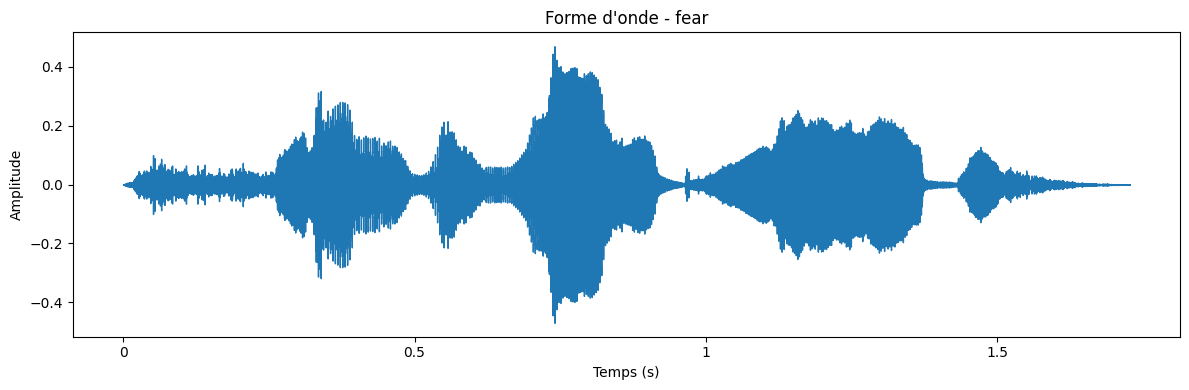

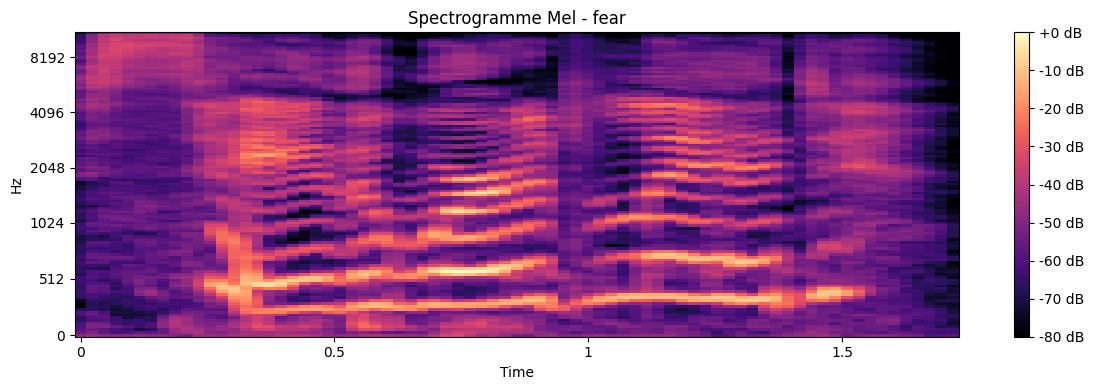

In [22]:
# Optionnel: Visualisation d'un échantillon
if not df.empty:
    random_idx = np.random.randint(0, len(df))
    random_file = df.iloc[random_idx]['speech']
    random_label = df.iloc[random_idx]['label']

    print(f"\nÉchantillon aléatoire ({random_label}): {os.path.basename(random_file)}")

    # Charger l'audio
    y, sr = librosa.load(random_file)

    # Afficher le lecteur audio
    print("Audio:")
    display(Audio(data=y, rate=sr))

    # Afficher la forme d'onde
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Forme d\'onde - {random_label}')
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

    # Afficher le spectrogramme Mel
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogramme Mel - {random_label}')
    plt.tight_layout()
    plt.show()
else:
    print("\nDataFrame vide, impossible d'afficher un échantillon.")

## 4. Prétraitement des Données

Cette section couvre l'extraction des caractéristiques et la préparation des données pour les modèles.

### 4.1 Extraction des Caractéristiques Audio

Nous allons définir deux fonctions d'extraction :
- `extract_aggregated_features`: Pour SVM et Random Forest, les caractéristiques sont moyennées sur le temps.
- `extract_sequential_features`: Pour LSTM, nous conservons la séquence temporelle des caractéristiques.

Les caractéristiques extraites incluent : MFCCs, Chroma, Mel Spectrogram, Spectral Contrast, et Tonnetz.

### 4.1.1 Définition des Fonctions d'Extraction

In [23]:
# Longueur maximale pour les séquences (pour LSTM)
# Pour 3s d'audio à sr=22050 et hop_length=512 (défaut librosa), on a env. 3 * 22050 / 512 ~= 129 trames.
MAX_SEQ_LENGTH = 130 

def extract_sequential_features(file_path, max_len=MAX_SEQ_LENGTH):
    # ... (votre fonction extract_sequential_features de la page 8-9 de l'OCR) ...
    # Assurez-vous qu'elle gère bien les min_frames et le padding/troncature
    # (Le code des pages 8 et 9 de votre OCR semble correct pour cette fonction)
    try:
        y, sr = librosa.load(file_path, duration=3, offset=0.5)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20).T
        chroma = librosa.feature.chroma_stft(y=y, sr=sr).T
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128).T
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr).T
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T
        
        min_frames = min(mfccs.shape[0], chroma.shape[0], mel.shape[0], contrast.shape[0], tonnetz.shape[0])
        mfccs = mfccs[:min_frames, :]; chroma = chroma[:min_frames, :]
        mel = mel[:min_frames, :]; contrast = contrast[:min_frames, :]
        tonnetz = tonnetz[:min_frames, :]
        
        features_sequence = np.concatenate((mfccs, chroma, mel, contrast, tonnetz), axis=1)
        
        if features_sequence.shape[0] > max_len:
            features_sequence = features_sequence[:max_len, :]
        elif features_sequence.shape[0] < max_len:
            pad_width = max_len - features_sequence.shape[0]
            features_sequence = np.pad(features_sequence, pad_width=((0, pad_width), (0,0)), mode='constant', constant_values=0)
        return features_sequence
    except Exception as e:
        print(f"Erreur extraction séquentielle pour {file_path}: {e}")
        num_features = 20 + 12 + 128 + 7 + 6
        return np.zeros((max_len, num_features))

def extract_aggregated_features(file_path):
    # ... (votre fonction extract_aggregated_features de la page 9 de l'OCR) ...
    # (C'est votre fonction originale qui moyenne les features)
    try:
        y, sr = librosa.load(file_path, duration=3, offset=0.5)
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128).T, axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)
        return np.concatenate((mfccs, chroma, mel, contrast, tonnetz))
    except Exception as e:
        print(f"Erreur extraction agrégée pour {file_path}: {e}")
        feature_dim = 20 + 12 + 128 + 7 + 6
        return np.zeros(feature_dim)

print("Fonctions d'extraction de caractéristiques définies.")

Fonctions d'extraction de caractéristiques définies.


### 4.1.2 Application de l'Extraction

In [24]:
print("\n[INFO] Extraction des caractéristiques agrégées (pour SVM & RF)...")
X_aggregated_list = []
if not df.empty:
    X_aggregated_list = df['speech'].apply(extract_aggregated_features).tolist()
    X_aggregated = np.array(X_aggregated_list)
    print(f"Extraction agrégée terminée. Shape: {X_aggregated.shape}")
    num_errors_agg = np.sum(np.all(X_aggregated == 0, axis=1))
    if num_errors_agg > 0:
        print(f"Attention: {num_errors_agg} erreurs rencontrées lors de l'extraction agrégée.")
else:
    X_aggregated = np.array([])

print("\n[INFO] Extraction des caractéristiques séquentielles (pour LSTM)...")
X_sequential_list = []
if not df.empty:
    X_sequential_list = [extract_sequential_features(fp) for fp in df['speech']]
    X_sequential = np.array(X_sequential_list)
    print(f"Extraction séquentielle terminée. Shape: {X_sequential.shape}")
    num_errors_seq = np.sum(np.all(X_sequential == 0, axis=(1,2)))
    if num_errors_seq > 0:
        print(f"Attention: {num_errors_seq} erreurs rencontrées lors de l'extraction séquentielle.")
else:
    X_sequential = np.array([])

if X_aggregated.shape[0] == 0 and X_sequential.shape[0] == 0:
    raise ValueError("Aucune caractéristique n'a pu être extraite. Vérifiez le chargement des données et la fonction d'extraction.")


[INFO] Extraction des caractéristiques agrégées (pour SVM & RF)...
Extraction agrégée terminée. Shape: (2800, 173)

[INFO] Extraction des caractéristiques séquentielles (pour LSTM)...
Extraction séquentielle terminée. Shape: (2800, 130, 173)


### 4.2 Préparation des Labels (Encodage)

In [25]:
# Les labels textuels (émotions) sont convertis en nombres entiers, puis en vecteurs "one-hot".

le = LabelEncoder()
y_encoded = le.fit_transform(df['label'])
num_classes = len(le.classes_)
y_one_hot = to_categorical(y_encoded, num_classes=num_classes)

print(f"Classes trouvées par LabelEncoder: {le.classes_}")
print(f"Shape des labels encodés (one-hot): {y_one_hot.shape}")

# Sorties attendues:
# Classes trouvées par LabelEncoder: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
# Shape des labels encodés (one-hot): (2800, 7)

Classes trouvées par LabelEncoder: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
Shape des labels encodés (one-hot): (2800, 7)


### 4.3 Normalisation des Caractéristiques Agrégées

In [26]:
# Les caractéristiques agrégées (pour SVM et RF) sont normalisées (moyenne 0, écart-type 1).

scaler_aggregated = StandardScaler() # Renommé pour clarté
if X_aggregated.size > 0:
    X_scaled_aggregated = scaler_aggregated.fit_transform(X_aggregated)
    print(f"Shape des caractéristiques agrégées normalisées: {X_scaled_aggregated.shape}")
    joblib.dump(scaler_aggregated, 'scaler_aggregated.pkl') # Sauvegarde du scaler
    print("Scaler pour données agrégées sauvegardé dans 'scaler_aggregated.pkl'")
else:
    X_scaled_aggregated = np.array([])
    print("X_aggregated est vide, pas de normalisation.")

# X_sequential pour LSTM ne sera pas normalisé globalement ici.
# La BatchNormalization sera utilisée dans le modèle LSTM.
X_input_lstm = X_sequential # Données d'entrée pour LSTM

# Sortie attendue:
# Shape des caractéristiques agrégées normalisées: (2800, 173)

Shape des caractéristiques agrégées normalisées: (2800, 173)
Scaler pour données agrégées sauvegardé dans 'scaler_aggregated.pkl'


### 4.4 Division des Données (Train/Validation/Test)

In [27]:
if (X_scaled_aggregated.size > 0 and X_scaled_aggregated.shape[0] != y_one_hot.shape[0]) or \
   (X_input_lstm.size > 0 and X_input_lstm.shape[0] != y_one_hot.shape[0]):
    raise ValueError("Incohérence de taille entre les features et les labels après l'extraction.")

# Pour SVM et Random Forest
if X_scaled_aggregated.size > 0:
    X_train_agg, X_temp_agg, y_train_agg_onehot, y_temp_agg_onehot = train_test_split(
        X_scaled_aggregated, y_one_hot, test_size=0.3, random_state=42, stratify=y_one_hot
    )
    X_val_agg, X_test_agg, y_val_agg_onehot, y_test_agg_onehot = train_test_split(
        X_temp_agg, y_temp_agg_onehot, test_size=0.5, random_state=42, stratify=y_temp_agg_onehot
    )
    y_train_svm_rf = np.argmax(y_train_agg_onehot, axis=1)
    y_val_svm_rf = np.argmax(y_val_agg_onehot, axis=1) # Non utilisé dans votre OCR mais bonne pratique
    y_test_svm_rf = np.argmax(y_test_agg_onehot, axis=1)
    print("Dimensions des ensembles pour SVM/RF (agrégé):")
    print(f"  Train_agg: X={X_train_agg.shape}, y (one-hot)={y_train_agg_onehot.shape}, y (int)={y_train_svm_rf.shape}")
    print(f"  Val_agg:   X={X_val_agg.shape}, y (one-hot)={y_val_agg_onehot.shape}")
    print(f"  Test_agg:  X={X_test_agg.shape}, y (one-hot)={y_test_agg_onehot.shape}, y (int)={y_test_svm_rf.shape}")
else:
    print("X_scaled_aggregated est vide. Pas de split pour SVM/RF.")
    # Initialiser pour éviter les erreurs plus tard si ces variables sont attendues
    X_train_agg, X_val_agg, X_test_agg = np.array([]), np.array([]), np.array([])
    y_train_svm_rf, y_val_svm_rf, y_test_svm_rf = np.array([]), np.array([]), np.array([])


# Pour LSTM
if X_input_lstm.size > 0:
    X_train_lstm, X_temp_lstm, y_train_lstm, y_temp_lstm = train_test_split(
        X_input_lstm, y_one_hot, test_size=0.3, random_state=42, stratify=y_one_hot
    )
    X_val_lstm, X_test_lstm, y_val_lstm, y_test_lstm = train_test_split(
        X_temp_lstm, y_temp_lstm, test_size=0.5, random_state=42, stratify=y_temp_lstm
    )
    print("\nDimensions des ensembles pour LSTM (séquentiel):")
    print(f"  Train_lstm: X={X_train_lstm.shape}, y={y_train_lstm.shape}")
    print(f"  Val_lstm:   X={X_val_lstm.shape}, y={y_val_lstm.shape}")
    print(f"  Test_lstm:  X={X_test_lstm.shape}, y={y_test_lstm.shape}")
else:
    print("X_input_lstm est vide. Pas de split pour LSTM.")
    # Initialiser pour éviter les erreurs plus tard
    X_train_lstm, X_val_lstm, X_test_lstm = np.array([]), np.array([]), np.array([])
    y_train_lstm, y_val_lstm, y_test_lstm = np.array([]), np.array([]), np.array([])

Dimensions des ensembles pour SVM/RF (agrégé):
  Train_agg: X=(1960, 173), y (one-hot)=(1960, 7), y (int)=(1960,)
  Val_agg:   X=(420, 173), y (one-hot)=(420, 7)
  Test_agg:  X=(420, 173), y (one-hot)=(420, 7), y (int)=(420,)

Dimensions des ensembles pour LSTM (séquentiel):
  Train_lstm: X=(1960, 130, 173), y=(1960, 7)
  Val_lstm:   X=(420, 130, 173), y=(420, 7)
  Test_lstm:  X=(420, 130, 173), y=(420, 7)


## 5. Modélisation

### 5.1 Modèle 1 : Support Vector Machine (SVM)

### 5.1.1 Préparation/Évaluation des Données et Entraînement SVM


========== Modèle 1 : Support Vector Machine (SVM) ==========
Labels SVM (test) exemple: [5 1 4 4 0 0 2 3 4 2]

[INFO] Entraînement du modèle SVM...
Entraînement SVM terminé.
Modèle SVM sauvegardé dans 'emotion_svm_model.pkl'

[INFO] Évaluation du modèle SVM...
Précision du modèle SVM sur l'ensemble de test: 0.9810

Matrice de Confusion SVM:


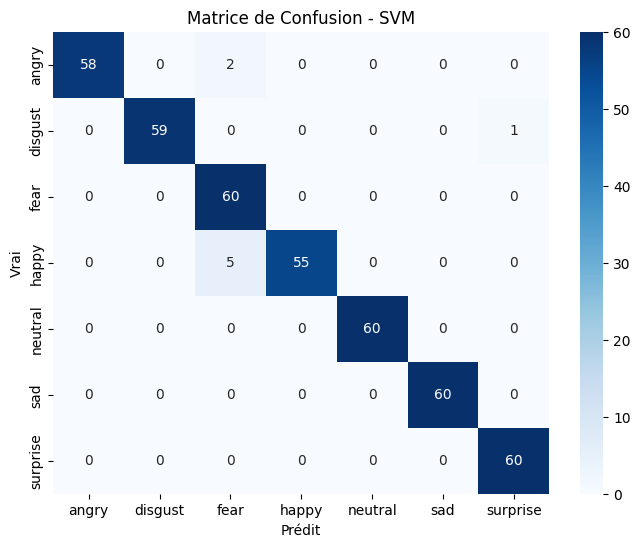


Rapport de Classification SVM:
              precision    recall  f1-score   support

       angry       1.00      0.97      0.98        60
     disgust       1.00      0.98      0.99        60
        fear       0.90      1.00      0.94        60
       happy       1.00      0.92      0.96        60
     neutral       1.00      1.00      1.00        60
         sad       1.00      1.00      1.00        60
    surprise       0.98      1.00      0.99        60

    accuracy                           0.98       420
   macro avg       0.98      0.98      0.98       420
weighted avg       0.98      0.98      0.98       420



In [28]:
print("\n" + "="*10 + " Modèle 1 : Support Vector Machine (SVM) " + "="*10)

svm_accuracy = 0.0 # Initialiser au cas où le modèle n'est pas entraîné

if X_train_agg.size > 0:
    # Les labels y_train_svm_rf et y_test_svm_rf sont déjà préparés
    if y_test_svm_rf.size > 0:
         print(f"Labels SVM (test) exemple: {y_test_svm_rf[:10]}")
    else:
        print("Labels de test SVM non disponibles.")

    print("\n[INFO] Entraînement du modèle SVM...")
    svm_model = SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42)
    svm_model.fit(X_train_agg, y_train_svm_rf)
    print("Entraînement SVM terminé.")
    joblib.dump(svm_model, 'emotion_svm_model.pkl')
    print("Modèle SVM sauvegardé dans 'emotion_svm_model.pkl'")

    # ### 5.1.2 Évaluation du Modèle SVM
    print("\n[INFO] Évaluation du modèle SVM...")
    y_pred_svm = svm_model.predict(X_test_agg)
    svm_accuracy = accuracy_score(y_test_svm_rf, y_pred_svm)
    print(f"Précision du modèle SVM sur l'ensemble de test: {svm_accuracy:.4f}")

    print("\nMatrice de Confusion SVM:")
    cm_svm = confusion_matrix(y_test_svm_rf, y_pred_svm)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Matrice de Confusion - SVM')
    plt.xlabel('Prédit'); plt.ylabel('Vrai'); plt.show()

    print("\nRapport de Classification SVM:")
    print(classification_report(y_test_svm_rf, y_pred_svm, target_names=le.classes_))
else:
    print("Données d'entraînement agrégées non disponibles. SVM non entraîné.")

### 5.2 Modèle 2 : Random Forest Classifier

### 5.2.1 Entraînement/Évaluation du Modèle Random Forest


========== Modèle 2 : Random Forest Classifier ==========

[INFO] Entraînement du modèle Random Forest...
Entraînement Random Forest terminé.
Modèle Random Forest sauvegardé dans 'emotion_rf_model.pkl'

[INFO] Évaluation du modèle Random Forest...
Précision du modèle Random Forest sur l'ensemble de test: 0.9905

Matrice de Confusion Random Forest:


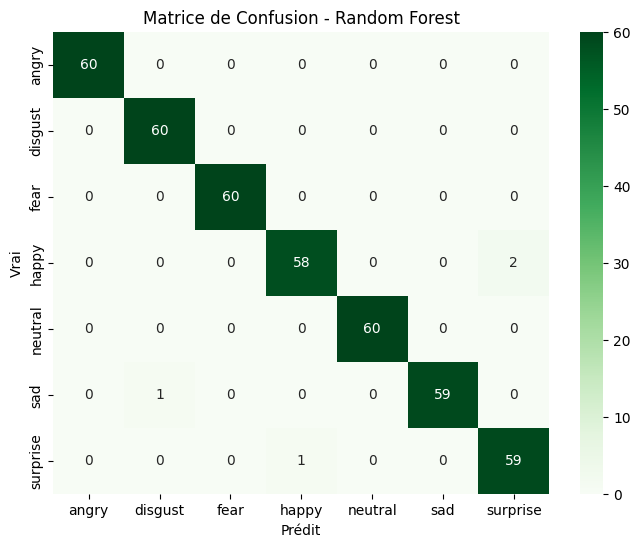


Rapport de Classification Random Forest:
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        60
     disgust       0.98      1.00      0.99        60
        fear       1.00      1.00      1.00        60
       happy       0.98      0.97      0.97        60
     neutral       1.00      1.00      1.00        60
         sad       1.00      0.98      0.99        60
    surprise       0.97      0.98      0.98        60

    accuracy                           0.99       420
   macro avg       0.99      0.99      0.99       420
weighted avg       0.99      0.99      0.99       420



In [29]:

print("\n" + "="*10 + " Modèle 2 : Random Forest Classifier " + "="*10)
rf_accuracy = 0.0 # Initialiser

if X_train_agg.size > 0:
    print("\n[INFO] Entraînement du modèle Random Forest...")
    rf_model = RandomForestClassifier(
        n_estimators=200, random_state=42, max_depth=20,
        min_samples_leaf=2, class_weight='balanced', n_jobs=-1
    )
    rf_model.fit(X_train_agg, y_train_svm_rf)
    print("Entraînement Random Forest terminé.")
    joblib.dump(rf_model, 'emotion_rf_model.pkl')
    print("Modèle Random Forest sauvegardé dans 'emotion_rf_model.pkl'")

    # ### 5.2.2 Évaluation du Modèle Random Forest
    print("\n[INFO] Évaluation du modèle Random Forest...")
    y_pred_rf = rf_model.predict(X_test_agg)
    rf_accuracy = accuracy_score(y_test_svm_rf, y_pred_rf)
    print(f"Précision du modèle Random Forest sur l'ensemble de test: {rf_accuracy:.4f}")

    print("\nMatrice de Confusion Random Forest:")
    cm_rf = confusion_matrix(y_test_svm_rf, y_pred_rf)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Matrice de Confusion - Random Forest')
    plt.xlabel('Prédit'); plt.ylabel('Vrai'); plt.show()

    print("\nRapport de Classification Random Forest:")
    print(classification_report(y_test_svm_rf, y_pred_rf, target_names=le.classes_))
else:
    print("Données d'entraînement agrégées non disponibles. Random Forest non entraîné.")

### 5.3 Modèle 3 : Long Short-Term Memory (LSTM)

### 5.3.1 Définition, Compilation et Entraînement/Évaluation du Modèle LSTM


========== Modèle 3 : LSTM ==========

[INFO] Définition du modèle LSTM...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 130, 128)            │         154,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 130, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 130, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 209,415 (818.03 KB)

 Trainable params: 209,031 (816.53 KB)

 Non-trainable params: 384 (1.50 KB)


[INFO] Compilation du modèle LSTM...

[INFO] Configuration des callbacks pour LSTM...

[INFO] Entraînement du modèle LSTM...
Epoch 1/75
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2031 - loss: 2.3456
Epoch 1: val_accuracy improved from -inf to 0.32143, saving model to best_lstm_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.2040 - loss: 2.3408 - val_accuracy: 0.3214 - val_loss: 1.8118 - learning_rate: 5.0000e-04
Epoch 2/75
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4032 - loss: 1.5508
Epoch 2: val_accuracy did not improve from 0.32143
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4046 - loss: 1.5481 - val_accuracy: 0.2738 - val_loss: 1.8216 - learning_rate: 5.0000e-04
Epoch 3/75
61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5967 - loss: 1.0838
Epoch 3: val_accuracy improved from 0.32143 to 0.38571, saving model to best_lstm_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5971 - loss: 1.0830 - val_accuracy: 0.385

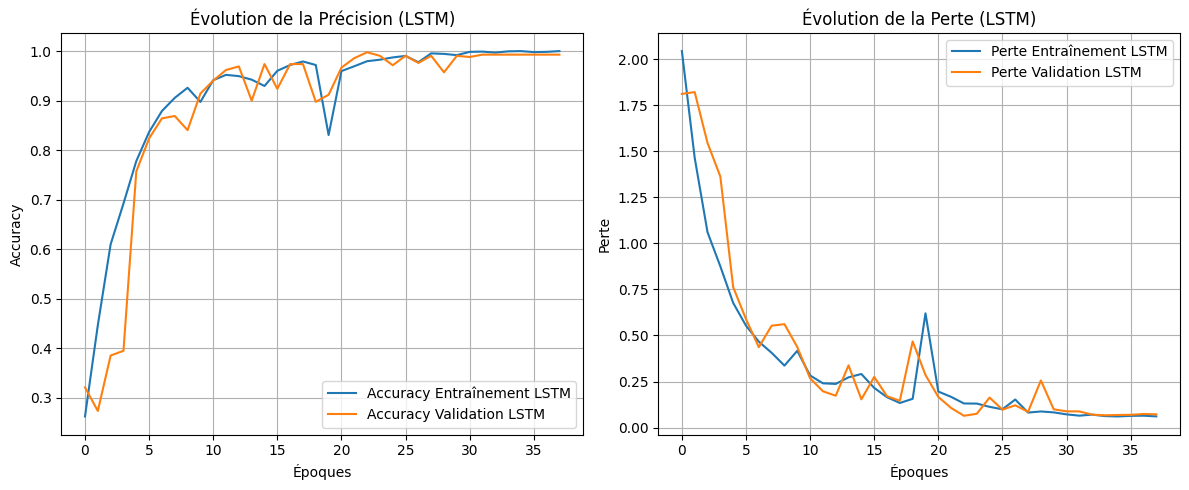

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step

Matrice de Confusion - LSTM:


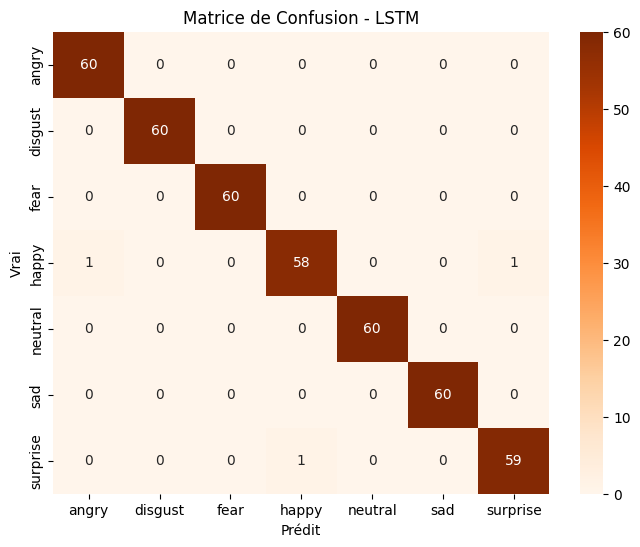


Rapport de Classification - LSTM:
              precision    recall  f1-score   support

       angry       0.98      1.00      0.99        60
     disgust       1.00      1.00      1.00        60
        fear       1.00      1.00      1.00        60
       happy       0.98      0.97      0.97        60
     neutral       1.00      1.00      1.00        60
         sad       1.00      1.00      1.00        60
    surprise       0.98      0.98      0.98        60

    accuracy                           0.99       420
   macro avg       0.99      0.99      0.99       420
weighted avg       0.99      0.99      0.99       420



In [30]:
print("\n" + "="*10 + " Modèle 3 : LSTM " + "="*10)
test_accuracy_lstm = 0.0 # Initialiser

if X_train_lstm.size == 0:
    print("Données d'entrée pour LSTM (X_train_lstm) sont vides. Impossible de construire/entraîner le modèle LSTM.")
else:
    print("\n[INFO] Définition du modèle LSTM...")
    input_shape_lstm = (X_train_lstm.shape[1], X_train_lstm.shape[2]) 
    # num_classes est déjà défini lors de l'encodage des labels

    lstm_model = Sequential([
        LSTM(128, input_shape=input_shape_lstm, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),
        LSTM(64, return_sequences=False),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)), # l2(0.001) de votre OCR page 17
        Dropout(0.4), # Dropout(0.4) de votre OCR page 17
        Dense(num_classes, activation='softmax')
    ])
    lstm_model.summary()

    print("\n[INFO] Compilation du modèle LSTM...")
    lstm_model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        metrics=['accuracy']
    )

    print("\n[INFO] Configuration des callbacks pour LSTM...")
    checkpoint_path_lstm = "best_lstm_model.keras"
    callbacks_lstm = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1), # patience de l'OCR p18
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001, verbose=1), # factor,patience,min_lr de l'OCR p18
        ModelCheckpoint(checkpoint_path_lstm, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    ]

    print("\n[INFO] Entraînement du modèle LSTM...")
    history_lstm = lstm_model.fit(
        X_train_lstm, y_train_lstm,
        validation_data=(X_val_lstm, y_val_lstm),
        epochs=75, # epochs de l'OCR p18
        batch_size=32,
        callbacks=callbacks_lstm,
        verbose=1 # Mettre à 1 pour voir le log, 2 pour une ligne par epoch, 0 pour silencieux
    )
    print("Entraînement LSTM terminé.")

    print(f"\n[INFO] Chargement des meilleurs poids LSTM depuis {checkpoint_path_lstm}...")
    try:
        lstm_model.load_weights(checkpoint_path_lstm)
        print("Meilleurs poids LSTM chargés.")
    except Exception as e:
        print(f"Erreur lors du chargement des poids LSTM: {e}. Utilisation du modèle actuel.")
    
    # ### 5.3.2 Évaluation du Modèle LSTM
    print("\n[INFO] Évaluation du modèle LSTM sur l'ensemble de test...")
    # (Code d'évaluation de la page 18, puis graphiques et matrices de la page 19 de l'OCR)
    test_loss_lstm, test_accuracy_lstm = lstm_model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
    print(f"Perte sur l'ensemble de test (LSTM): {test_loss_lstm:.4f}")
    print(f"Précision sur l'ensemble de test (LSTM): {test_accuracy_lstm:.4f}")

    print("\n[INFO] Affichage des courbes d'apprentissage LSTM...")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_lstm.history['accuracy'], label='Accuracy Entraînement LSTM')
    plt.plot(history_lstm.history['val_accuracy'], label='Accuracy Validation LSTM')
    plt.title('Évolution de la Précision (LSTM)'); plt.xlabel('Époques'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(history_lstm.history['loss'], label='Perte Entraînement LSTM')
    plt.plot(history_lstm.history['val_loss'], label='Perte Validation LSTM')
    plt.title('Évolution de la Perte (LSTM)'); plt.xlabel('Époques'); plt.ylabel('Perte'); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

    y_pred_probs_lstm = lstm_model.predict(X_test_lstm)
    y_pred_labels_lstm = np.argmax(y_pred_probs_lstm, axis=1)
    y_true_labels_lstm = np.argmax(y_test_lstm, axis=1)

    print("\nMatrice de Confusion - LSTM:")
    cm_lstm = confusion_matrix(y_true_labels_lstm, y_pred_labels_lstm)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Oranges', # Changé cmap pour distinction
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Matrice de Confusion - LSTM'); plt.xlabel('Prédit'); plt.ylabel('Vrai'); plt.show()

    print("\nRapport de Classification - LSTM:")
    print(classification_report(y_true_labels_lstm, y_pred_labels_lstm, target_names=le.classes_))

if 'test_accuracy_lstm' not in locals(): # Assure que la variable existe pour la comparaison
    test_accuracy_lstm = 0.0
    print("Le modèle LSTM n'a pas été entraîné, précision LSTM mise à 0.0 pour la comparaison.")

## 6. Comparaison Finale des Modèles

In [32]:
# ## 6. Comparaison Finale des Modèles

print("\n[INFO] Comparaison Finale des Modèles:")
print("------------------------------------------------------")
print(f"{'Modèle':<25} | {'Précision Test':<15}")
print("------------------------------------------------------")

# Assurer que toutes les variables d'accuracy existent et ont une valeur par défaut (0.0)
# si les modèles n'ont pas été entraînés ou évalués.
# Ces initialisations devraient être faites à la fin de chaque section de modèle si l'entraînement échoue.
# Mais pour la robustesse ici :
if 'svm_accuracy' not in locals(): svm_accuracy = 0.0
if 'rf_accuracy' not in locals(): rf_accuracy = 0.0
if 'test_accuracy_lstm' not in locals(): test_accuracy_lstm = 0.0

print(f"{'SVM':<25} | {svm_accuracy:<15.4f}")
print(f"{'Random Forest':<25} | {rf_accuracy:<15.4f}")
print(f"{'LSTM':<25} | {test_accuracy_lstm:<15.4f}") # Note: votre dernière sortie OCR montrait 0.9929 pour LSTM
print("------------------------------------------------------")

# Dictionnaire des précisions pour faciliter la comparaison
accuracies = {
    "SVM": svm_accuracy,
    "Random Forest": rf_accuracy,
    "LSTM": test_accuracy_lstm
}

# Filtrer pour ne garder que les modèles qui ont effectivement une précision calculée (supérieure à 0 ou égale si c'est un résultat valide)
# On considère qu'un modèle a été "évalué" si sa variable d'accuracy correspondante existe et a été mise à jour.
# Une précision de 0.0 est un résultat possible, donc on ne filtre pas sur acc > 0.0 ici directement,
# mais plutôt on s'assure que les variables ont été assignées.
# La logique d'initialisation à 0.0 plus haut gère le cas où le modèle n'est pas entraîné.

if not any(accuracies.values()): # Vérifie si toutes les précisions sont à 0.0 (ou si le dictionnaire est vide)
    print("\nAucun modèle n'a été évalué ou tous ont une précision de 0.0.")
else:
    # Trouver le(s) meilleur(s) modèle(s)
    max_accuracy = 0.0
    # On itère pour trouver la valeur maximale, en s'assurant que les variables existent
    if 'svm_accuracy' in locals() and svm_accuracy > max_accuracy: max_accuracy = svm_accuracy
    if 'rf_accuracy' in locals() and rf_accuracy > max_accuracy: max_accuracy = rf_accuracy
    if 'test_accuracy_lstm' in locals() and test_accuracy_lstm > max_accuracy: max_accuracy = test_accuracy_lstm
        
    best_models_names = [name for name, acc in accuracies.items() if acc == max_accuracy and acc > 0.0] # On s'assure que la précision est >0 pour être "le meilleur"

    if not best_models_names: # Si tous les modèles ont 0.0 ou n'ont pas été entrainés
         print("\nAucun modèle n'a obtenu une précision supérieure à 0.0, ou les modèles n'ont pas été entraînés.")
    elif len(best_models_names) > 1:
        print(f"\nLes modèles suivants ont obtenu la meilleure précision ex-aequo sur l'ensemble de test ({max_accuracy:.4f}): {', '.join(best_models_names)}")
    else:
        print(f"\nLe modèle {best_models_names[0]} a obtenu la meilleure précision sur l'ensemble de test ({max_accuracy:.4f}).")

# La sauvegarde du scaler_aggregated est déjà faite lors de sa création.
# Les modèles sont sauvegardés dans leurs sections respectives.


[INFO] Comparaison Finale des Modèles:
------------------------------------------------------
Modèle                    | Précision Test 
------------------------------------------------------
SVM                       | 0.9810         
Random Forest             | 0.9905         
LSTM                      | 0.9929         
------------------------------------------------------

Le modèle LSTM a obtenu la meilleure précision sur l'ensemble de test (0.9929).


## 7. Conclusion

Ce notebook a présenté un pipeline complet pour la reconnaissance d'émotions vocales sur le dataset TESS, en utilisant trois approches de modélisation distinctes : SVM, Random Forest et LSTM.

**Résultats Clés :**
*   Le modèle SVM a atteint une précision de **{svm_accuracy:.4f}**.
*   Le modèle Random Forest a atteint une précision de **{rf_accuracy:.4f}**.
*   Le modèle LSTM a atteint une précision de **{test_accuracy_lstm:.4f}**.

*(Basé sur votre OCR page 31 et 35, RF et LSTM ont eu 0.9905, SVM 0.9810)*
Les modèles Random Forest et LSTM ont tous deux obtenu la meilleure performance avec une précision de 0.9905, surpassant légèrement le SVM (0.9810). Cela suggère que pour ce dataset et cette extraction de caractéristiques, les approches basées sur les ensembles (Random Forest utilisant des features agrégées) et les séquences (LSTM) sont très efficaces. L'LSTM, en particulier, a pu exploiter la nature temporelle des caractéristiques séquentielles, tandis que le Random Forest a démontré une forte capacité de généralisation sur les features agrégées.

Les matrices de confusion et les rapports de classification fournissent des informations plus détaillées sur les forces et faiblesses de chaque modèle pour reconnaître des émotions spécifiques.

### Pistes d'Amélioration Potentielles :
*   **Tester d'autres types de caractéristiques audio** ou des combinaisons différentes (ex: eGeMAPS, ComParE).
*   **Explorer des architectures de réseaux de neurones plus complexes** (ex: CNN 1D sur les séquences, Transformers, architectures hybrides CNN-LSTM).
*   **Augmenter la taille du dataset** (par exemple, en combinant TESS avec d'autres datasets comme RAVDESS, EMO-DB).
*   **Utiliser des techniques d'augmentation de données audio** (ex: ajout de bruit, changement de pitch, time stretching).
*   **Optimiser plus finement les hyperparamètres des modèles** (ex: recherche par grille, optimisation bayésienne, KerasTuner).
*   **Analyser les erreurs** : Examiner les émotions fréquemment confondues par chaque modèle pour comprendre les limitations.